# CELL 1: Environment Setup & Package Installation

In [1]:
"""
CELL 1: Environment Setup & Package Installation
Purpose: Install required packages and suppress warnings
"""

# Install core packages
!pip install --upgrade pip
!pip uninstall -y transformers tokenizers accelerate -q
!pip install "transformers==4.56.0" "protobuf>=5.29.4" -q
!pip install torch datasets -q
!pip install pandas matplotlib seaborn tqdm wandb pyyaml
!pip install bitsandbytes accelerate

# Suppress warnings for clean output
import warnings
import os
warnings.filterwarnings("ignore", category=UserWarning)
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

print("✅ Packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 29.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
peft 0.16.0 requires accelerate>=0.21.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; pla

# CELL 2: Core Imports

In [2]:
"""
CELL 2: Core Imports
Purpose: Import all necessary libraries
"""
"Built-in libraries"
import re
import sys
import gc
import time
import json
import hashlib
import glob
import zipfile
from io import StringIO
from datetime import datetime
from typing import Dict, List, Optional, Tuple, Any
import yaml
import logging
import random

"Deep learning and NLP libraries"
import torch
import torch.nn.functional as F
from transformers import (
    AutoConfig, 
    AutoTokenizer, 
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    GenerationConfig,
    logging as hf_logging
)

"Data processing libraries"
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from tqdm.auto import tqdm
from IPython import get_ipython

# Configure logging
logging.getLogger("ContinuousBatchingLogger").setLevel(logging.ERROR)
hf_logging.set_verbosity_error()

print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
!nvidia-smi

Python Version: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch Version: 2.6.0+cu124
CUDA Available: True
CUDA Version: 12.4
Sun Dec 14 15:26:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8             12W /   70W |       3MiB /  15360MiB |      0%      Default |
|   

# CELL 3: Environment Detection & Path Configuration

In [3]:
"""
CELL 3: Environment Detection & Path Configuration
Purpose: Detect runtime environment (Colab/Kaggle/Local) and set paths
"""

def configure_environment_paths():
    """Detect environment and configure paths"""
    try:
        if 'google.colab' in str(get_ipython()):
            print("✅ Environment: Google Colab")
            base_data_path = '/content/'
            base_output_path = '/content/output/'
            environment_name = 'colab'
        elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE'):
            print("✅ Environment: Kaggle")
            base_data_path = '/kaggle/input/'
            base_output_path = '/kaggle/working/'
            environment_name = 'kaggle'
        else:
            print("⚠️ Environment: Local/Unknown")
            base_data_path = './data/'
            base_output_path = './output/'
            environment_name = 'local'
    except NameError:
        print("⚠️ Non-interactive session. Using local paths.")
        base_data_path = './data/'
        base_output_path = './output/'
        environment_name = 'local'
    
    os.makedirs(base_output_path, exist_ok=True)
    print(f"📂 Data Path: {base_data_path}")
    print(f"📦 Output Path: {base_output_path}")
    
    return base_data_path, base_output_path, environment_name

def auto_unzip_colab_content(target_dir='/content/', zip_extension='*.zip'):
    """Auto-extract zip files in Colab environment"""
    if 'google.colab' not in str(get_ipython()):
        return
    
    print(f"🔎 Scanning for {zip_extension} files...")
    zip_files = glob.glob(os.path.join(target_dir, zip_extension))
    
    for zip_path in zip_files:
        file_name = os.path.basename(zip_path)
        base_name = os.path.splitext(file_name)[0]
        expected_output = os.path.join(target_dir, base_name)
        
        if os.path.exists(expected_output) and os.listdir(expected_output):
            print(f"➡️ Skipping '{file_name}' (already extracted)")
            continue
        
        try:
            print(f"📂 Extracting: {file_name}...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(target_dir)
        except Exception as e:
            print(f"❌ Error: {e}")

# Initialize paths
DATA_PATH, OUTPUT_PATH, ENV = configure_environment_paths()
auto_unzip_colab_content(DATA_PATH)

# Optional: WandB login
try:
    from google.colab import userdata
    wandb_key = userdata.get('WANDB_API_KEY')
    if wandb_key:
        wandb.login(key=wandb_key)
except:
    pass

✅ Environment: Kaggle
📂 Data Path: /kaggle/input/
📦 Output Path: /kaggle/working/


# CELL 4: Data Generation Utilities

In [4]:
"""
CELL 4: Data Generation Utilities
Purpose: Functions to create test datasets and perplexity data
"""

def create_test_datasets(config: dict) -> Dict[str, List[Dict]]:
    """
    Generate algorithmic test datasets strictly matching ICLR 2025 specs:
    1. N-ary Addition: Input-Output pairs, 3-digit operands, sum.
    2. P-hop Induction: Sequence length 256, Alphabet 4, Chain embedded at random sorted indices.
    3. Symbolic i-GSM: Hierarchy depth 4, strict Level i -> Level i+1 dependency, Modulo 7.
    """
    test_data = {}
    
    # 1. N-ARY ADDITION (Unchanged, matches paper description)
    if 'n_ary' in config:
        n_ary_data = []
        ops_levels = config['n_ary'].get('ops_levels', [8, 16, 24, 32])
        num_samples = config['n_ary'].get('num_samples_per_level', 30)
        
        for n in ops_levels:
            for _ in range(num_samples):
                # Paper: sample operands [0, 999] uniformly
                nums_int = [random.randint(0, 999) for _ in range(n)]
                # Format: "315 + 120 + ... ="
                nums_str = [str(x).zfill(3) for x in nums_int]
                
                prompt_str = " + ".join(nums_str) + " ="
                target_str = str(sum(nums_int))

                n_ary_data.append({
                    "prompt": prompt_str,
                    "expected_answer": target_str,
                    "difficulty": f"{n}_ops",
                    "task_type": "n_ary"
                })
        test_data['n_ary'] = n_ary_data

    # 2. P-HOP INDUCTION
    # Description: "Picking the sequence of p-hops randomly... shuffling them around in a sequence... 
    # sample remaining characters in place of filler tokens while respecting the p-hop order."
    if 'p_hop' in config:
        p_hop_data = []
        alphabet = ['A', 'B', 'C', 'D']
        seq_len = 256
        hop_levels = config['p_hop'].get('hop_levels', [16, 24, 32])
        num_samples = config['p_hop'].get('num_samples_per_level', 30)

        for p in hop_levels:
            for _ in range(num_samples):
                # 1. Define the Chain: v_0 -> v_1 -> ... -> v_p
                # The 'hop' logic implies identifying v_i and finding v_{i+1}
                chain = [random.choice(alphabet) for _ in range(p + 1)]
                
                # 2. Embed in Sequence
                # "Shuffling them around... respecting p-hop order" implies:
                # We pick p+1 random positions in the 256-length sequence 
                # and place the chain items there in strictly increasing order.
                indices = random.sample(range(seq_len), p + 1)
                indices.sort()
                
                # Initialize sequence with "filler" logic
                # "Sample remaining characters... in place of filler tokens"
                seq = [random.choice(alphabet) for _ in range(seq_len)]
                
                # Overwrite fillers with the chain at the selected indices
                for k, idx in enumerate(indices):
                    seq[idx] = chain[k]
                
                # 3. Construct Prompt
                # Input: Sequence + Start Node. Goal: Output the p-th hop (last item in chain).
                seq_str = "".join(seq)
                start_node = chain[0]
                expected = chain[-1]
                
                full_prompt = f"Sequence: {seq_str}. Start: {start_node}. Hop {p} times."
                
                p_hop_data.append({
                    "prompt": full_prompt,
                    "expected_answer": expected,
                    "difficulty": f"{p}_hops",
                    "task_type": "p_hop"
                })
        test_data['p_hop'] = p_hop_data

    # 3. SYMBOLIC i-GSM
    # Description: "Hierarchy of depth 4... edges connect level i to level i+1... 
    # instance parameter is integer... arithmetic modulo 7... symbolic language"
    if 'igsm' in config:
        igsm_data = []
        num_total = config['igsm'].get('num_samples_total', 50)
        
        # Variable naming pool (e.g., E#I, K#N)
        chars = "ABCDEFGHIJKLMNOP"
        def get_var_name():
            return f"{random.choice(chars)}#{random.choice(chars)}"

        for _ in range(num_total):
            # 1. Structure: Hierarchy Depth 4 (Levels 0 to 4)
            # We assign variables to specific levels
            levels = {0: [], 1: [], 2: [], 3: [], 4: []}
            all_vars_data = {} # {name: val}
            equations = []
            
            # 2. Level 0: Roots (Constants)
            # Create ~4 root entities
            for _ in range(4):
                name = get_var_name()
                val = random.randint(0, 6) # Modulo 7
                levels[0].append(name)
                all_vars_data[name] = val
                equations.append(f"{name} := {val}")

            # 3. Levels 1 to 4: Dependencies
            # "Edges connect entities in level i to those in level i+1"
            for i in range(1, 5):
                # Number of variables in this level
                num_vars_in_level = random.randint(2, 4)
                
                for _ in range(num_vars_in_level):
                    target_var = get_var_name()
                    
                    # Ensure unique names
                    while target_var in all_vars_data:
                        target_var = get_var_name()
                    
                    # Select 1 or 2 operands from the PREVIOUS level (i-1)
                    # This enforces the strict hierarchy described
                    operands = random.choices(levels[i-1], k=random.randint(1, 2))
                    op_vals = [all_vars_data[op] for op in operands]
                    
                    op_type = random.choice(['add', 'sub', 'mult', 'assign'])
                    
                    stmt = ""
                    res = 0
                    
                    if op_type == 'assign' or len(operands) < 2:
                        stmt = f"{target_var} := {operands[0]}"
                        res = op_vals[0]
                    elif op_type == 'add':
                        stmt = f"{target_var} := {operands[0]} + {operands[1]}"
                        res = (op_vals[0] + op_vals[1]) % 7
                    elif op_type == 'sub':
                        stmt = f"{target_var} := {operands[0]} - {operands[1]}"
                        res = (op_vals[0] - op_vals[1]) % 7
                    elif op_type == 'mult':
                        stmt = f"{target_var} := {operands[0]} * {operands[1]}"
                        res = (op_vals[0] * op_vals[1]) % 7
                        
                    equations.append(stmt)
                    all_vars_data[target_var] = res
                    levels[i].append(target_var)

            # 4. Query
            # "Pick one of the nodes... compute value"
            # We pick from the deepest level (Level 4) to ensure the full chain is needed
            target_var = random.choice(levels[4])
            target_val = all_vars_data[target_var]
            
            # Shuffle equations to ensure model learns the dependency graph, not just order
            random.shuffle(equations)
            
            # Format: "Question. Eq1. Eq2. ... EqN. Target?"
            full_prompt = "Question. " + ". ".join(equations) + f". {target_var}?"
            
            igsm_data.append({
                "prompt": full_prompt,
                "expected_answer": str(target_val),
                "difficulty": "depth_4_hierarchical_mod_7",
                "task_type": "igsm"
            })
            
    test_data['igsm'] = igsm_data
    
    return test_data

def create_perplexity_data(num_samples: int = 30) -> List[str]:
    """Generate reasoning traces for perplexity calculation"""
    perplexity_texts = []
    
    # N-ARY traces
    for _ in range(num_samples // 2):
        n = random.choice([4, 6, 8])
        nums = [random.randint(10, 99) for _ in range(n)]
        trace = f"System: You are a calculation engine.\nUser: Sum: {nums}\nAssistant: Current Sum: 0\n"
        
        current_sum = 0
        for num in nums:
            prev_sum = current_sum
            current_sum += num
            trace += f"Add {num}: {prev_sum} + {num} = {current_sum}\nCurrent Sum: {current_sum}\n"
        
        trace += f"Final: {current_sum}"
        perplexity_texts.append(trace)
    
    # P-HOP traces
    all_letters = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    for _ in range(num_samples // 2):
        hops = random.choice([3, 4, 5])
        nodes = random.sample(all_letters, hops + 1)
        facts = [f"{nodes[i]}->{nodes[i+1]}" for i in range(len(nodes) - 1)]
        facts_str = ", ".join(facts)
        
        trace = f"System: Logic engine.\nUser: Facts: {facts_str}. Start: {nodes[0]}. Find: {nodes[-1]}.\n"
        trace += f"Assistant: Current Node: {nodes[0]}\n"
        
        for i in range(hops):
            trace += f"Rule Matches: {nodes[i]} -> {nodes[i+1]}\nNext Node: {nodes[i+1]}\n"
        
        trace += f"Final: {nodes[-1]}"
        perplexity_texts.append(trace)
    
    return perplexity_texts


def load_and_preprocess_data(file_path: str) -> Dict[str, List[Dict]]:
    """Load existing test data from JSON or CSV"""
    print(f"Loading data from: {file_path}")
    
    if file_path.endswith('.json'):
        with open(file_path, 'r', encoding='utf-8') as f:
            raw_data = json.load(f)
    elif file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
        raw_data = df.to_dict('records')
    else:
        raise ValueError("Unsupported format. Use .json or .csv")
    
    processed_data = {'n_ary': [], 'p_hop': [], 'igsm': []}
    
    for record in raw_data:
        task = record.get('task_type')
        if task in processed_data:
            if all(k in record for k in ['prompt', 'expected_answer', 'difficulty']):
                processed_data[task].append(record)
    
    print(f"✅ Loaded - N-ary: {len(processed_data['n_ary'])}, "
          f"P-Hop: {len(processed_data['p_hop'])}, iGSM: {len(processed_data['igsm'])}")
    
    return processed_data


def generate_test_id(task_type: str, difficulty: str, prompt: str) -> str:
    """Generate unique test ID"""
    unique_str = f"{task_type}_{difficulty}_{prompt}"
    return hashlib.md5(unique_str.encode()).hexdigest()[:8]


print("✅ Data generation utilities loaded")

✅ Data generation utilities loaded


# CELL 5: Core Experiment Class

In [5]:
"""
CELL 5: Core Experiment Class
Purpose: Main class for running Ouro model experiments (Updated for ICLR 2025 Formats)
"""

class OuroThinkingExperiment:
    """Core experiment class for Ouro model testing"""
    
    def __init__(self, model_path: str, dtype=torch.float16, 
                 use_4bit_quant: bool = False, use_torch_compile: bool = False):
        torch.cuda.empty_cache()
        self.model_path = model_path
        self.dtype = dtype
        self.use_4bit_quant = use_4bit_quant
        self.use_torch_compile = use_torch_compile
        self.tokenizer = None
        self.task_templates = {}
    
    def load_model_with_ut_steps(self, total_ut_steps: int, early_exit_threshold: float):
        """Load model with specific UT steps configuration"""
        quantization_config = None
        if self.use_4bit_quant:
            print("→ Applying 4-bit quantization")
            quantization_config = BitsAndBytesConfig(load_in_4bit=True)
        
        print(f"Loading model: UT steps={total_ut_steps}, Early exit={early_exit_threshold}")
        
        config = AutoConfig.from_pretrained(self.model_path, trust_remote_code=True)
        config.total_ut_steps = total_ut_steps
        config.early_exit_threshold = early_exit_threshold
        
        tokenizer = AutoTokenizer.from_pretrained(
            self.model_path,
            trust_remote_code=True,
            padding_side="left"
        )
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        
        model = AutoModelForCausalLM.from_pretrained(
            self.model_path,
            config=config,
            device_map="cuda",
            attn_implementation="sdpa_paged",
            dtype=self.dtype if not self.use_4bit_quant else None,
            trust_remote_code=True,
            quantization_config=quantization_config
        )
        
        if self.use_torch_compile:
            print("→ Applying torch.compile()")
            model = torch.compile(model)
        
        model.eval()
        print(f"✅ Model loaded on {model.device}")
        
        return model, tokenizer, None, {
            "total_ut_steps": total_ut_steps,
            "early_exit_threshold": early_exit_threshold
        }
    
    def _build_task_templates(self, tokenizer):
            """
            Pre-compute prompt templates for faster inference.
            UPDATED: Refined Few-Shot examples to prevent babbling (added Step Prefixes and Guardrails).
            """
            self.tokenizer = tokenizer
            
            task_configs = {
                # 1. N-ARY ADDITION (TÍCH HỢP STEP PREFIX VÀ GUARDRAILS)
                "n_ary": {
                    # Thêm từ khóa kiểm soát: MUST, DO NOT
                    "system": "You are a mechanical calculation engine. Your output MUST be strictly sequential. DO NOT output introductions, explanations, or any text outside of the required calculation steps.",
                    "example_user": "10 + 20 + 30 =",
                    # Thêm [STEP X] và [FINAL]
                    "example_asst": "[STEP 1] Current: 0\n[STEP 2] Add 10: 0 + 10 = 10\n[STEP 3] Current: 10\n[STEP 4] Add 20: 10 + 20 = 30\n[STEP 5] Current: 30\n[STEP 6] Add 30: 30 + 30 = 60\n[FINAL] 60",
                    # Bắt đầu bằng ngắt dòng và ký hiệu bước đầu tiên
                    "force_start": "\n[STEP 1] Current: 0", 
                    "input_prefix": "" 
                },
                
                # 2. P-HOP INDUCTION (Rút gọn và Thêm Guardrail)
                "p_hop": {
                    # Thêm từ khóa kiểm soát và yêu cầu kết thúc chỉ với token
                    "system": "You are an induction head mechanism. Strictly trace the sequence occurrences step-by-step. Do not provide any commentary or auxiliary information. End your response ONLY with the final traced token.",
                    "example_user": "Sequence: A B C D A B. Start: A. Hop 1 times.",
                    # Rút gọn ví dụ: dùng [TRACE]
                    "example_asst": "\n[TRACE] Start at A. Found 'A' in sequence. Next token is B.\n[FINAL] B",
                    "force_start": "\n[TRACE] Start at", 
                    "input_prefix": "" 
                },
                
                # 3. SYMBOLIC i-GSM (Thêm Step Prefix và Guardrail)
                "igsm": {
                    # Tăng cường Guardrail
                    "system": "You are a symbolic math solver. You must solve the DAG modulo 7. Your reasoning MUST be concise, equation-based, and step-by-step. DO NOT generate preambles or verbose explanations.",
                    "example_user": "Question. E#I := 4. E#J := E#I. F#K := E#J. H#J := E#J + F#K. H#J?",
                    # Thêm [EQ X] cho từng bước và [FINAL]
                    "example_asst": "\n[EQ 1] E#I = 4. [EQ 2] E#J = E#I. ==> E#J = 4. [EQ 3] F#K = E#J. ==> F#K = 4. [EQ 4] H#J = E#J + F#K. ==> H#J = 1.\n[FINAL] 1",
                    "force_start": "\n[EQ 1]", 
                    "input_prefix": "" 
                }
            }
            
            for task_type, config in task_configs.items():
                # 1. Build static context (Unchanged logic)
                static_messages = [
                    {"role": "system", "content": config["system"]},
                    {"role": "user", "content": config["example_user"]},
                    {"role": "assistant", "content": config["example_asst"]}
                ]
                
                static_prompt_text = tokenizer.apply_chat_template(
                    static_messages, tokenize=False, add_generation_prompt=True
                )
                static_inputs = tokenizer(static_prompt_text, return_tensors="pt")
                
                # 2. Tokenize Force Start (Unchanged logic)
                force_start_tokens = tokenizer(
                    config["force_start"], 
                    return_tensors="pt", 
                    add_special_tokens=False
                )
                
                self.task_templates[task_type] = {
                    "static_input_ids": static_inputs.input_ids,
                    "static_attention_mask": static_inputs.attention_mask,
                    "force_start_ids": force_start_tokens.input_ids,
                    "input_prefix": config["input_prefix"],
                    "force_start_text": config["force_start"]
                }
            
            print("[+] Task templates pre-computed (Corrected with Step Prefixes and Guardrails)")
    
    def _extract_final_answer(self, full_response: str, task_type: str) -> str:
        """Extract answer from model response"""
        pred = "0"
        
        try:
            if task_type == "p_hop":
                patterns = [
                    r"Final\s*:\s*(\w+)",
                    r"Next token is\s*(\w+)",
                    r"Answer\s*:\s*(\w+)",
                ]
                for pattern in patterns:
                    match = re.search(pattern, full_response, re.IGNORECASE)
                    if match:
                        pred = match.group(1).strip()
                        break
                else:
                    pred = "Error"
            else:
                patterns = [
                    r"Final\s*:\s*([-+]?\d*\.?\d+)",
                    r"Answer\s*:\s*([-+]?\d*\.?\d+)",
                    r"=\s*([-+]?\d*\.?\d+)$" # Catches "5 + 2 = 7" at end
                ]
                all_matches = []
                for pattern in patterns:
                    matches = re.findall(pattern, full_response, re.IGNORECASE)
                    all_matches.extend(matches)
                
                if all_matches:
                    pred = all_matches[-1]
        except Exception as e:
            print(f"[!] Parsing error: {e}")
            pred = "ParseError"
        
        return pred
    
    @torch.no_grad()
    def predict_with_metrics_optimized(self, user_input: str, task_type: str, 
                                      model, tokenizer, ut_steps: int, 
                                      generation_config: dict = None):
        """Optimized prediction with repetition penalty to prevent loops"""
        if not hasattr(self, 'task_templates') or task_type not in self.task_templates:
            self._build_task_templates(tokenizer)
        
        template = self.task_templates[task_type]
        device = model.device
        
        # Construct Input
        input_ids = template["static_input_ids"].to(device)
        user_query = template["input_prefix"] + user_input
        user_tokens = tokenizer(user_query, return_tensors="pt", 
                               add_special_tokens=False).input_ids.to(device)
        force_start_ids = template["force_start_ids"].to(device)
        
        input_ids = torch.cat([input_ids, user_tokens, force_start_ids], dim=1)
        attention_mask = torch.ones_like(input_ids, device=device)
        
        # Improved Generation Config
        start_time = time.perf_counter()
        
        gen_config = generation_config or {
            'max_new_tokens': 1024,
            'do_sample': False,
            'num_beams': 1,
            'min_length': 5
        }
        
        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pad_token_id=tokenizer.eos_token_id,
            use_cache=True,
            return_dict_in_generate=True,
            output_scores=False,
            **gen_config
        )
        
        generation_time = time.perf_counter() - start_time
        
        # Decode
        prompt_length = input_ids.shape[1]
        generated_ids = outputs.sequences[0, prompt_length:]
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        
        full_response = template["force_start_text"] + generated_text
        pred = self._extract_final_answer(full_response, task_type)
        
        return {
            'full_response': full_response,
            'prediction': pred,
            'generation_time': generation_time,
            'generated_tokens': generated_ids.shape[0],
            'input_tokens': input_ids.shape[1],
            'ut_steps': ut_steps
        }
    
    @torch.no_grad()
    def calculate_perplexity(self, model, tokenizer, text_data: List[str], 
                            ut_steps: int, max_length: int = 2048, stride: int = 512):
        """Calculate perplexity using sliding window"""
        device = model.device
        model.eval()
        
        if not text_data or not text_data[0]:
            return float('nan'), float('nan')
        
        text_concat = text_data[0]
        encodings = tokenizer(text_concat, return_tensors='pt', 
                            max_length=max_length * 2, truncation=True)
        input_ids = encodings.input_ids.to(device)
        attention_mask = encodings.attention_mask.to(device)
        
        if input_ids.size(1) < 2:
            return float('nan'), float('nan')
        
        total_loss = 0.0
        total_tokens = 0
        
        for i in tqdm(range(0, input_ids.size(1), stride), 
                     desc=f"Calculating PPL (UT={ut_steps})"):
            end_loc = min(i + max_length, input_ids.size(1))
            input_slice = input_ids[:, i:end_loc]
            target_slice = input_slice.clone()
            
            if i > 0:
                context_len = input_slice.size(1) - stride
                if context_len > 0:
                    target_slice[:, :context_len] = -100
            
            if (target_slice != -100).sum() == 0:
                continue
            
            outputs = model(
                input_ids=input_slice,
                attention_mask=attention_mask[:, i:end_loc],
                labels=target_slice
            )
            
            if torch.isnan(outputs.loss):
                continue
            
            num_valid = (target_slice != -100).sum().item()
            total_loss += (outputs.loss * num_valid).item()
            total_tokens += num_valid
        
        if total_tokens == 0:
            return float('nan'), float('nan')
        
        avg_loss = total_loss / total_tokens
        perplexity = torch.exp(torch.tensor(avg_loss)).item()
        
        return perplexity, avg_loss


print("✅ OuroThinkingExperiment class loaded")

✅ OuroThinkingExperiment class loaded


# CELL 6: Batch Experiment Class

In [6]:
"""
CELL 6: Batch Experiment Class
Purpose: Extended class with batch processing support
"""

class OuroBatchExperiment(OuroThinkingExperiment):
    """Extended experiment class with batch processing"""
    
    def __init__(self, model_path: str, dtype=torch.float16, 
                 use_4bit_quant: bool = False, use_torch_compile: bool = False,
                 max_batch_size: int = 4, max_new_tokens: int = 1024):
        super().__init__(model_path, dtype, use_4bit_quant, use_torch_compile)
        self.max_batch_size = max_batch_size
        self.max_new_tokens = max_new_tokens
    
    def prepare_batch_inputs(self, prompts: List[str], task_type: str) -> List[List[int]]:
        """Prepare inputs for batch generation"""
        if task_type not in self.task_templates:
            raise ValueError("Templates not built. Call _build_task_templates first.")
        
        template = self.task_templates[task_type]
        
        batch_texts = [template["input_prefix"] + p for p in prompts]
        user_encodings = self.tokenizer(batch_texts, add_special_tokens=False)
        
        static_ids = template["static_input_ids"].squeeze(0).tolist()
        force_ids = template["force_start_ids"].squeeze(0).tolist()
        
        input_id_lists = []
        for user_ids in user_encodings['input_ids']:
            full_seq = static_ids + user_ids + force_ids
            input_id_lists.append(full_seq)
        
        return input_id_lists
    
    @torch.no_grad()
    def batch_predict_with_metrics(self, prompts: List[str], task_type: str,
                                   model, tokenizer, ut_steps: int,
                                   generation_config: Optional[GenerationConfig] = None):
        """Batch prediction with metrics"""
        if not prompts:
            return []
        
        simple_batch_inputs = self.prepare_batch_inputs(prompts, task_type)
        input_lengths = [len(ids) for ids in simple_batch_inputs]
        
        if not hasattr(model, 'generate_batch'):
            print("⚠️ Model doesn't support generate_batch(). Using sequential.")
            return self._sequential_fallback(prompts, task_type, model, 
                                            tokenizer, ut_steps, generation_config)
        
        if generation_config is None:
            generation_config = GenerationConfig(
                max_new_tokens=self.max_new_tokens,
                use_cuda_graph=False,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.pad_token_id,
                do_sample=False,
                max_batch_tokens=self.max_batch_size * self.max_new_tokens,
            )
        
        start_time = time.perf_counter()
        
        try:
            batch_outputs = model.generate_batch(
                inputs=simple_batch_inputs,
                generation_config=generation_config,
            )
        except Exception as e:
            print(f"⚠️ generate_batch failed: {e}. Falling back.")
            return self._sequential_fallback(prompts, task_type, model, 
                                            tokenizer, ut_steps, generation_config)
        
        batch_time = time.perf_counter() - start_time
        
        template = self.task_templates[task_type]
        results = [None] * len(prompts)
        request_ids = list(batch_outputs.keys())
        
        # Map outputs to prompts
        if all(isinstance(rid, int) for rid in request_ids):
            for request_id in request_ids:
                if 0 <= request_id < len(prompts):
                    output = batch_outputs[request_id]
                    results[request_id] = self._process_single_output(
                        output, request_id, input_lengths[request_id],
                        template, tokenizer, task_type, ut_steps,
                        batch_time / len(prompts)
                    )
        else:
            # String/UUID request IDs
            input_to_index = {
                " ".join(map(str, inp)): idx 
                for idx, inp in enumerate(simple_batch_inputs)
            }
            
            for request_id in request_ids:
                output = batch_outputs[request_id]
                
                if hasattr(output, 'prompt_ids'):
                    input_key = " ".join(map(str, output.prompt_ids))
                    if input_key in input_to_index:
                        idx = input_to_index[input_key]
                        results[idx] = self._process_single_output(
                            output, idx, len(output.prompt_ids),
                            template, tokenizer, task_type, ut_steps,
                            batch_time / len(prompts)
                        )
        
        # Fill missing results
        for i in range(len(prompts)):
            if results[i] is None:
                results[i] = {
                    'full_response': 'ERROR: No output',
                    'prediction': 'ERROR',
                    'generation_time': batch_time / len(prompts),
                    'generated_tokens': 0,
                    'input_tokens': input_lengths[i],
                    'ut_steps': ut_steps
                }
        
        return results
    
    def _process_single_output(self, output, prompt_idx: int, input_length: int,
                               template: dict, tokenizer, task_type: str,
                               ut_steps: int, sample_time: float):
        """Process single batch output"""
        if hasattr(output, 'generated_tokens'):
            generated_ids = output.generated_tokens
        elif hasattr(output, 'sequences') and len(output.sequences) > 0:
            generated_ids = output.sequences[0]
        else:
            generated_ids = []
        
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)
        full_response = template["force_start_text"] + generated_text
        
        pred = self._extract_final_answer(full_response, task_type)
        
        return {
            'full_response': full_response,
            'prediction': pred,
            'generation_time': sample_time,
            'generated_tokens': len(generated_ids),
            'input_tokens': input_length,
            'ut_steps': ut_steps,
            'prompt_idx': prompt_idx
        }
    
    def _sequential_fallback(self, prompts, task_type, model, tokenizer, 
                            ut_steps, generation_config):
        """Fallback to sequential processing"""
        results = []
        for prompt in tqdm(prompts, desc=f"Sequential fallback ({task_type})"):
            result = self.predict_with_metrics_optimized(
                user_input=prompt,
                task_type=task_type,
                model=model,
                tokenizer=tokenizer,
                ut_steps=ut_steps,
                generation_config=generation_config
            )
            results.append(result)
        return results

print("✅ OuroBatchExperiment class loaded")

✅ OuroBatchExperiment class loaded


# CELL 7: Main Experiment Runner

In [7]:
"""
CELL 7: Main Experiment Runner
Purpose: Function to execute the full experiment pipeline with batching and logging
"""

def run_batch_experiment(config: dict):
    """
    Run experiment with batching support and W&B logging.
    Returns: (accuracy_results, perplexity_results)
    """
    # 1. Initialize W&B
    use_wandb = config.get('WANDB', {}).get('enabled', False)
    run = None
    
    if use_wandb:
        wb_conf = config['WANDB']
        print(f"🔗 Initializing W&B (timeout: {wb_conf.get('timeout', 30)}s)...")
        
        os.environ['WANDB__SERVICE_WAIT'] = '300'
        
        try:
            run = wandb.init(
                project=wb_conf.get('project', 'ouro-looped-transformer'),
                entity=wb_conf.get('entity', None),
                name=wb_conf.get('run_name', f"run_{int(time.time())}"),
                config=config,
                mode=wb_conf.get('mode', 'online'),
                settings=wandb.Settings(start_timeout=wb_conf.get('timeout', 30), _disable_stats=True)
            )
            print("✅ W&B initialized")
        except Exception as e:
            print(f"⚠️ W&B failed: {e}. Continuing offline.")
            use_wandb = False
            run = None

    # 2. Extract Config
    model_path = config['MODEL']['path']
    ut_steps_list = config['INFERENCE_STEPS']
    data_config = config['DATA']
    eval_settings = config['EVAL_SETTINGS']
    
    # 3. Setup Experiment
    experiment = OuroBatchExperiment(
        model_path, 
        dtype=config['MODEL']['dtype'],
        use_4bit_quant=config['MODEL'].get('use_4bit_quant', True),
        use_torch_compile=config['MODEL'].get('use_torch_compile', True),
        max_batch_size=config.get('OPTIMIZATION', {}).get('max_batch_size', 4),
        max_new_tokens=config.get('OPTIMIZATION', {}).get('max_new_token', 1024)
    )
    
    torch.manual_seed(42)
    
    # 4. Prepare Data
    if data_config['load_existing']:
        test_datasets = load_and_preprocess_data(data_config['data_file_path'])
    else:
        print("Generating new test datasets...")
        test_datasets = create_test_datasets(data_config)
    
    perplexity_results = []
    perplexity_data = []
    if eval_settings['calculate_perplexity']:
        raw_ppl_data = create_perplexity_data(eval_settings['ppl_num_samples'])
        perplexity_data = ["\n\n".join(raw_ppl_data)]
    
    all_results = []
    
    # 5. Main Loop
    for ut_steps in ut_steps_list:
        print(f"\n{'='*60}\n🧪 EXPERIMENT: UT Steps = {ut_steps}\n{'='*60}")
        
        # Load fresh model
        model, tokenizer, _, _ = experiment.load_model_with_ut_steps(
            ut_steps, eval_settings['early_exit_threshold']
        )
        
        if not hasattr(experiment, '_templates_precomputed'):
            experiment._build_task_templates(tokenizer)
            experiment._templates_precomputed = True
        
        # A. Perplexity
        if perplexity_data:
            print(f"📉 Calculating PPL...")
            ppl, avg_loss = experiment.calculate_perplexity(
                model, tokenizer, perplexity_data, ut_steps,
                max_length=eval_settings['ppl_max_length'],
                stride=eval_settings['ppl_stride']
            )
            perplexity_results.append({'ut_steps': ut_steps, 'perplexity': ppl, 'avg_loss': avg_loss})
            print(f"✅ PPL: {ppl:.4f} | Loss: {avg_loss:.4f}")
            
            if use_wandb:
                wandb.log({"perplexity": ppl, "val_loss": avg_loss, "ut_steps": ut_steps})
        
        # B. Accuracy & Time
        enable_batch = config.get('OPTIMIZATION', {}).get('enable_batch', True)
        
        for task_type, items in test_datasets.items():
            print(f"\n📝 Task: {task_type} ({len(items)} samples)")
            task_results = []
            start_time = time.time()
            
            # Determine batch strategy
            batch_size = 1
            if enable_batch:
                limits = {'n_ary': 8, 'p_hop': 4, 'igsm': 2}
                batch_size = min(limits.get(task_type, 1), experiment.max_batch_size)
            
            # Process Loop
            if batch_size > 1 and len(items) >= 2:
                # Batched Processing
                for i in range(0, len(items), batch_size):
                    batch_items = items[i : i + batch_size]
                    prompts = [item['prompt'] for item in batch_items]
                    
                    batch_out = experiment.batch_predict_with_metrics(
                        prompts, task_type, model, tokenizer, ut_steps
                    )
                    
                    for res, item in zip(batch_out, batch_items):
                        res_entry = _create_result_entry(res, item, task_type, ut_steps)
                        task_results.append(res_entry)
                        all_results.append(res_entry)
            else:
                # Sequential Processing
                for item in tqdm(items, desc=f"  {task_type}", leave=False):
                    res = experiment.predict_with_metrics_optimized(
                        item['prompt'], task_type, model, tokenizer, ut_steps
                    )
                    res_entry = _create_result_entry(res, item, task_type, ut_steps)
                    task_results.append(res_entry)
                    all_results.append(res_entry)
            
            # Logging
            _log_task_summary(task_results, task_type, ut_steps, start_time, use_wandb)
        
        # Cleanup
        del model, tokenizer
        torch.cuda.empty_cache()
        gc.collect()
    
    # Final W&B Close
    if use_wandb and run:
        wandb.finish()
        
    return all_results, perplexity_results

def _create_result_entry(result, item, task_type, ut_steps):
    """Helper to format result dictionary"""
    pred = str(result['prediction']).strip().lower()
    target = str(item['expected_answer']).strip().lower()
    
    is_correct = False
    if task_type == 'p_hop':
        is_correct = pred == target
    else:
        try:
            is_correct = abs(float(pred) - float(target)) < 0.001
        except:
            is_correct = pred == target
            
    return {
        'task_type': task_type,
        'difficulty': item.get('difficulty', 'unknown'),
        'test_input': item['prompt'],
        'expected_answer': item['expected_answer'],
        'is_correct': is_correct,
        'test_id': generate_test_id(task_type, item.get('difficulty', ''), item['prompt']),
        'ut_steps': ut_steps,
        **result
    }

def _log_task_summary(results, task_type, ut_steps, start_time, use_wandb):
    if not results: return
    
    acc = sum(r['is_correct'] for r in results) / len(results)
    avg_time = sum(r['generation_time'] for r in results) / len(results)
    duration = time.time() - start_time
    
    print(f"    📊 Acc={acc:.2%} | Time/Sample={avg_time:.3f}s | Total={duration:.1f}s")
    
    if use_wandb:
        wandb.log({
            f"{task_type}/accuracy": acc,
            f"{task_type}/avg_time": avg_time,
            "ut_steps": ut_steps
        })

print("✅ Main experiment runner loaded")

✅ Main experiment runner loaded


# CELL 8: Analysis Utilities

In [8]:
"""
CELL 8: Analysis Utilities
Purpose: Functions to analyze, clean, and merge results
"""

def analyze_experiment_results(accuracy_results: list, perplexity_results: list = None):
    """Generate summary statistics dataframe"""
    if not accuracy_results:
        return pd.DataFrame()
    
    df = pd.DataFrame(accuracy_results)
    
    # Group by UT steps and task
    summary = df.groupby(['ut_steps', 'task_type']).agg({
        'is_correct': ['mean', 'count', 'std'],
        'generation_time': ['mean', 'min', 'max'],
        'generated_tokens': ['mean']
    }).round(3)
    
    # Flatten columns
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    return summary

def load_and_process_results(file_path: str):
    """Load results CSV and add derived features"""
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        return pd.DataFrame()
        
    # Feature engineering
    if 'generated_tokens' not in df.columns:
        df['generated_tokens'] = df['full_response'].apply(
            lambda x: len(re.findall(r'\S+', str(x))) if pd.notna(x) else 0
        )
    
    # Type conversion
    df['is_correct'] = df['is_correct'].astype(bool)
    df['ut_steps'] = pd.to_numeric(df['ut_steps'], errors='coerce').astype('Int64')
    
    return df

print("✅ Analysis utilities loaded")

✅ Analysis utilities loaded


# CELL 9: Configuration

In [9]:
"""
CELL 9: Configuration
Purpose: Define experiment parameters
"""

BatchConfig = {
    # --- Model Settings ---
    'MODEL': {
        'path': "ByteDance/Ouro-1.4B-Thinking",
        'dtype': torch.bfloat16,
        'use_4bit_quant': False,      # Set True if low VRAM
        'use_torch_compile': True     # Optimization
    },

    # --- Experiment Scope ---
    'INFERENCE_STEPS': [1],           # List of loop counts to test (e.g., [1, 2, 4])

    # --- Evaluation Logic ---
    'EVAL_SETTINGS': {
        'calculate_perplexity': True,
        'early_exit_threshold': -1.0, # -1 disables early exit
        'ppl_num_samples': 50,
        'ppl_max_length': 2048,
        'ppl_stride': 512,
    },

    # --- Logging ---
    'WANDB': {
        'enabled': True,
        'project': "ouro-trace",
        'run_name': f"run_{datetime.now().strftime('%Y%m%d_%H%M')}",
        'entity': None,
        'mode': 'offline',            # Use 'online' to sync
    },

    # --- Data Generation ---
    'DATA': {
        'load_existing': False,
        'data_file_path': '',
        'n_ary': {'ops_levels': [4, 8], 'num_samples_per_level': 10},
        'p_hop': {'hop_levels': [2, 4], 'num_samples_per_level': 10},
        'igsm': {'num_samples_total': 20}
    },

    # --- Performance Optimization ---
    'OPTIMIZATION': {
        'enable_batch': True,
        'max_batch_size': 8,
        'max_new_token': 1024
    }
}

print("✅ Configuration loaded")

✅ Configuration loaded


# CELL 10: Execution & Visualization

🕒 Timestamp: 20251214_152700

🚀 STARTING EXPERIMENT
🔗 Initializing W&B (timeout: 30s)...
⚠️ W&B failed: 1 validation error for Settings
start_timeout
  Extra inputs are not permitted [type=extra_forbidden, input_value=30, input_type=int]
    For further information visit https://errors.pydantic.dev/2.12/v/extra_forbidden. Continuing offline.
Generating new test datasets...

🧪 EXPERIMENT: UT Steps = 1
Loading model: UT steps=1, Early exit=-1.0


config.json: 0.00B [00:00, ?B/s]

configuration_ouro.py: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

modeling_ouro.py: 0.00B [00:00, ?B/s]

2025-12-14 15:27:03.982586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765726024.141083      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765726024.187384      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

model.safetensors:   0%|          | 0.00/2.87G [00:00<?, ?B/s]

→ Applying torch.compile()
✅ Model loaded on cuda:0
[+] Task templates pre-computed (Corrected with Step Prefixes and Guardrails)
📉 Calculating PPL...


Calculating PPL (UT=1):   0%|          | 0/8 [00:00<?, ?it/s]

W1214 15:27:49.926000 47 torch/_inductor/utils.py:1137] [0/0] Not enough SMs to use max_autotune_gemm mode


✅ PPL: 8.9785 | Loss: 2.1948

📝 Task: n_ary (20 samples)


Solving 4 requests: 100%|██████████| 4/4 [00:44<00:00, 11.04s/request]


    📊 Acc=35.00% | Time/Sample=10.778s | Total=215.6s

📝 Task: p_hop (20 samples)


Solving 4 requests: 100%|██████████| 4/4 [00:04<00:00,  1.04s/request]


    📊 Acc=35.00% | Time/Sample=1.073s | Total=21.5s

📝 Task: igsm (20 samples)


Solving 2 requests: 100%|██████████| 2/2 [00:09<00:00,  4.93s/request]


    📊 Acc=55.00% | Time/Sample=15.442s | Total=308.8s

💾 Results saved to /kaggle/working/

📊 VISUALIZATION

--- Summary Statistics ---
                    is_correct_mean  is_correct_count  is_correct_std  \
ut_steps task_type                                                      
1        igsm                  0.55                20           0.510   
         n_ary                 0.35                20           0.489   
         p_hop                 0.35                20           0.489   

                    generation_time_mean  generation_time_min  \
ut_steps task_type                                              
1        igsm                     15.442                2.318   
         n_ary                    10.778                3.114   
         p_hop                     1.073                1.043   

                    generation_time_max  generated_tokens_mean  
ut_steps task_type                                              
1        igsm                    58.764   

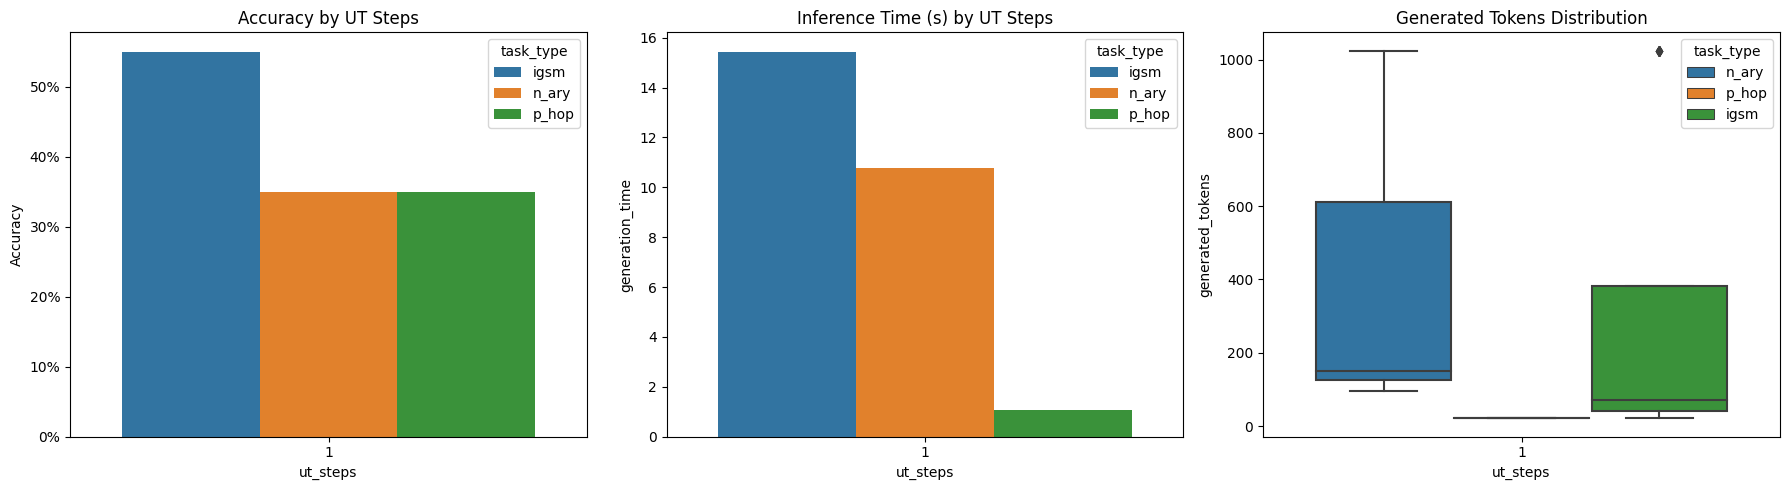


🏁 Experiment Complete.



In [10]:
"""
CELL 10: Execution & Visualization
Purpose: Run the experiment, save results, and visualize outcomes
"""

# 1. Setup
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f"🕒 Timestamp: {timestamp}")
print("\n" + "="*50 + "\n🚀 STARTING EXPERIMENT\n" + "="*50)

# 2. Run
results_acc, results_ppl = run_batch_experiment(BatchConfig)

# 3. Save Results
df_acc = pd.DataFrame(results_acc)
df_ppl = pd.DataFrame(results_ppl)

RUN_RESULTS_NAME = f"run_{timestamp}"
os.makedirs(os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME))
acc_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_acc_{timestamp}.csv")
ppl_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_ppl_{timestamp}.csv")
cfg_path = os.path.join(OUTPUT_PATH, RUN_RESULTS_NAME, f"ouro_config_{timestamp}.yaml")

df_acc.to_csv(acc_path, index=False)
if not df_ppl.empty:
    df_ppl.to_csv(ppl_path, index=False)

# Save Config
def sanitize_config(cfg):
    """Convert config to YAML-safe format"""
    clean = {}
    for k, v in cfg.items():
        if isinstance(v, dict):
            clean[k] = sanitize_config(v)
        elif str(type(v)).find('torch.') != -1:
            clean[k] = str(v)
        else:
            clean[k] = v
    return clean

with open(cfg_path, 'w') as f:
    yaml.dump(sanitize_config(BatchConfig), f)

print(f"\n💾 Results saved to {OUTPUT_PATH}")

# 4. Visualization & Reporting
if not df_acc.empty:
    print("\n" + "="*50 + "\n📊 VISUALIZATION\n" + "="*50)
    
    # Summary Tables
    summary = analyze_experiment_results(results_acc)
    print("\n--- Summary Statistics ---")
    print(summary)
    
    # Plotting
    try:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Plot 1: Accuracy
        acc_summary = df_acc.groupby(['task_type', 'ut_steps'])['is_correct'].mean().reset_index()
        sns.barplot(data=acc_summary, x='ut_steps', y='is_correct', hue='task_type', ax=axes[0])
        axes[0].set_title('Accuracy by UT Steps')
        axes[0].set_ylabel('Accuracy')
        axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
        
        # Plot 2: Time
        time_summary = df_acc.groupby(['task_type', 'ut_steps'])['generation_time'].mean().reset_index()
        sns.barplot(data=time_summary, x='ut_steps', y='generation_time', hue='task_type', ax=axes[1])
        axes[1].set_title('Inference Time (s) by UT Steps')
        
        # Plot 3: Token Count
        sns.boxplot(data=df_acc, x='ut_steps', y='generated_tokens', hue='task_type', ax=axes[2])
        axes[2].set_title('Generated Tokens Distribution')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"⚠️ Visualization error: {e}")
else:
    print("⚠️ No results to visualize.")

print("\n🏁 Experiment Complete.\n")

In [11]:
print("Final Inspection:\n")
print("Top 20 Accuracy Report:\n")
print(df_acc.head(20))
print(f"Full Response:\n")
print(df_acc['full_response'])
print("Perplexity Report:\n")
print(df_ppl.head(20))

Final Inspection:

Top 20 Accuracy Report:

   task_type difficulty                                       test_input  \
0      n_ary      4_ops                          969 + 763 + 500 + 313 =   
1      n_ary      4_ops                          237 + 353 + 914 + 403 =   
2      n_ary      4_ops                          984 + 573 + 379 + 966 =   
3      n_ary      4_ops                          320 + 844 + 579 + 302 =   
4      n_ary      4_ops                          962 + 178 + 464 + 521 =   
5      n_ary      4_ops                          145 + 286 + 461 + 906 =   
6      n_ary      4_ops                          591 + 913 + 635 + 102 =   
7      n_ary      4_ops                          903 + 887 + 110 + 026 =   
8      n_ary      4_ops                          478 + 729 + 504 + 600 =   
9      n_ary      4_ops                          262 + 850 + 494 + 859 =   
10     n_ary      8_ops  088 + 284 + 750 + 175 + 182 + 184 + 394 + 183 =   
11     n_ary      8_ops  647 + 691 + 601 + 6

In [13]:
print(df_acc[['full_response', 'generated_tokens']])

                                        full_response  generated_tokens
0   \n[STEP 1] Current: 0\n[STEP 2] Add 969: 0 + 9...               126
1   \n[STEP 1] Current: 0\n[STEP 2] Add 200: 0 + 2...               110
2   \n[STEP 1] Current: 0\n[STEP 2] Add 984: 0 + 9...               126
3   \n[STEP 1] Current: 0\n[STEP 2] Add 320: 0 + 3...               156
4   \n[STEP 1] Current: 0\n[STEP 2] Add 962: 0 + 9...               126
5   \n[STEP 1] Current: 0\n[STEP 2] Add 10: 0 + 10...               279
6   \n[STEP 1] Current: 0\n[STEP 2] Add 591: 0 + 5...               126
7   \n[STEP 1] Current: 0\n[STEP 2] Add 903: 0 + 9...               126
8   \n[STEP 1] Current: 0\n[STEP 2] Add 478: 0 + 4...               126
9   \n[STEP 1] Current: 0\n[STEP 2] Add 200: 0 + 2...               143
10  \n[STEP 1] Current: 0\n[STEP 2] Add 10: 0 + 10...                96
11  \n[STEP 1] Current: 0\n[STEP 2] Add 10: 0 + 10...              1024
12  \n[STEP 1] Current: 0\n[STEP 2] Add 10: 0 + 10...           